# Imports and Constants

In [15]:
import random
import tqdm
import tqdm.notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
import torch
import torch.nn as nn

In [17]:
%matplotlib inline
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')
random.seed(0)

In [19]:
# Keys
SCENE_IDX = 'scene_idx'
P_IN = 'p_in'
V_IN = 'v_in'
P_OUT = 'p_out'
V_OUT = 'v_out'

# Header of predictions CSV file
CSV_HEADER = ['ID,'] + ['v' + str(i) + ',' for i in range(1, 60)] + ['v60', '\n']

TRAIN_TEST_RATIO = 0.80
BATCH_SIZE_TRAIN = 256
BATCH_SIZE_TEST = 256
BATCH_SIZE_VAL = 64
N_WORKERS = 0

MODEL_STATE = 'model_state_dict'
OPTIMIZER_STATE = 'optimizer_state_dict'
EPOCH_STATE = 'epoch'
LOSS_STATE = 'loss'
BATCH_STATE = 'batch'
SCHEDULER_STATE = 'scheduler_state_dict'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
def get_original_data(PIN, VIN, POUT):
    # Build the dataset
    original_data = []
    iterator = tqdm.notebook.tqdm(zip(PIN.iterrows(), VIN.iterrows(), POUT.iterrows()), total=len(PIN))
    for (i1, r1), (_, r2), (_, r3) in iterator:
        d = {
            SCENE_IDX: r1[0], 
            P_IN: r1.to_numpy()[1:].reshape(19, 2),
            V_IN: r2.to_numpy()[1:].reshape(19, 2),
            P_OUT: r3.to_numpy()[1:].reshape(30, 2)
        }
        original_data.append(d)    
    
    return original_data

def get_train_test_data(original_data, ratio):
    # Split into train and test
    random.shuffle(original_data)
    TRAIN_SIZE = int(len(original_data) * ratio)
    train_data = original_data[:TRAIN_SIZE]
    test_data = original_data[TRAIN_SIZE:]
    return train_data, test_data
    
def get_val_data(PIN, VIN):
    val_data = []
    iterator = tqdm.notebook.tqdm(zip(PIN.iterrows(), VIN.iterrows()), total=len(PIN))
    for (i1, r1), (_, r2) in iterator:
        d = {
            SCENE_IDX: r1[0], 
            P_IN: r1.to_numpy()[1:].reshape(19, 2),
            V_IN: r2.to_numpy()[1:].reshape(19, 2)
        }
        val_data.append(d)
   
    return val_data

def get_data(kind):
    # Train/test data
    if kind == 'single':
        PIN = pd.read_csv('./targ_train_data/pin_train.csv')
        VIN = pd.read_csv('./targ_train_data/vin_train.csv')
        POUT = pd.read_csv('./targ_train_data/pout_train.csv')

    else:    
        # All tracked agents
        PIN = pd.read_csv('./track_train_data/pin_trainall.csv')
        VIN = pd.read_csv('./track_train_data/vin_trainall.csv')
        POUT = pd.read_csv('./track_train_data/pout_trainall.csv')
        
    original_data = get_original_data(PIN, VIN, POUT)
    train_data, test_data = get_train_test_data(original_data, TRAIN_TEST_RATIO)
    
    # Validation data
    PIN = pd.read_csv('./targ_val_data/pin_val.csv')
    VIN = pd.read_csv('./targ_val_data/vin_val.csv')        
    val_data = get_val_data(PIN, VIN)
    
    return train_data, test_data, val_data

# Dataset Loading and Batching

In [21]:
class ArgoverseDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super(ArgoverseDataset, self).__init__()
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]      

In [22]:
def collate_train_test(batch):
    """ 
    Custom collate_fn function to be used for DataLoader.    
    """    
    inp = []     
    out = []
    scene_idxs = []
    offsets = np.zeros((len(batch), 2))
    for i, scene in enumerate(batch):      
        pin, vin, pout = np.copy(scene[P_IN]), np.copy(scene[V_IN]), np.copy(scene[P_OUT])
        
        # Normalize position
        xs, ys = pin[0, 0], pin[0, 1]       
        pin[:, 0] -= xs
        pin[:, 1] -= ys
        pout[:, 0] -= xs
        pout[:, 1] -= ys

        inp_tens = np.concatenate((pin, vin), axis=1)     
        out_tens = pout
        
        inp.append(inp_tens)
        out.append(out_tens)  
        scene_idxs.append(scene[SCENE_IDX])
        offsets[i, 0] = xs
        offsets[i, 1] = ys

    inp = torch.FloatTensor(inp)
    out = torch.FloatTensor(out)
    return [inp, out, scene_idxs, offsets]

In [23]:
def collate_val(batch):
    """ 
    Custom collate_fn for validation dataset. The validation data do not contain output values.   
    The input tensor is organized as 19 rows, where each row has 4 columns: px, py, vx, vy
    """   
    inp = []
    scene_idxs = []
    offsets = np.zeros((len(batch), 2))  # start (x, y) coordinates from normalization
    
    for i, scene in enumerate(batch):          
        pin, vin = np.copy(scene[P_IN]), np.copy(scene[V_IN])

        # Normalize position
        xs, ys = pin[0, 0], pin[0, 1]      
        pin[:, 0] -= xs
        pin[:, 1] -= ys
        
        inp_tens = np.concatenate((pin, vin), axis=1)        
        inp.append(inp_tens)        
        scene_idxs.append(scene[SCENE_IDX])
        
        offsets[i, 0] = xs
        offsets[i, 1] = ys
    inp = torch.FloatTensor(inp)    
    return [inp, scene_idxs, offsets]

# Training Workflow

In [24]:
def train(model, device, train_loader, optimizer, epoch, train_data):
    # Set the model into training mode
    model.train()      
    # Define the loss function.
    criterion = torch.nn.MSELoss(reduction='mean')

    total_loss = 0    
    for i in range(epoch):
        iterator = tqdm.notebook.tqdm(train_loader, total=int(len(train_loader)))
        for _, batch in enumerate(iterator):
            data, target, _, _ = batch
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()  
            
            out = model(data)
            # Compute the loss       
            loss = torch.sqrt(criterion(out, target)) 
            total_loss += loss.item()

            # Perform backpropagation
            loss.backward()
            # Update the weights
            optimizer.step()    
            
#             scheduler.step()  # Uncomment if using CyclicLR

            # Update the progress bar for tqdm
            iterator.set_postfix(train_loss=loss.item())
            
    return (total_loss * BATCH_SIZE_TRAIN) / len(train_data)

In [25]:
def test(model, device, test_loader, test_data):
    model.eval()    
    criterion = torch.nn.MSELoss(reduction='mean') 

    iterator = tqdm.notebook.tqdm(test_loader, total=int(len(test_loader)))
    total_loss = 0    
    for _, batch in enumerate(iterator):
        data, target, _, _ = batch
        data, target = data.to(device), target.to(device)
        
        with torch.no_grad():
            out = model(data)            
            loss = torch.sqrt(criterion(out, target))        
            total_loss += loss.item()

            iterator.set_postfix(test_loss=loss.item())
                    
    return (total_loss * BATCH_SIZE_TEST) / len(test_data)

In [26]:
def validate(model, device, val_loader, path):
    """
    path: path to csv file to write predictions
    """
    model.eval() 
    
    # Prep the output file
    with open(path, "w") as csv_file:
        # Clear the csv file before appending data to it
        csv_file.truncate()
        # Write the header to the csv file
        csv_file.writelines(CSV_HEADER)    
    
    # Make predictions
    with open(path, "a") as pred_file:        
        iterator = tqdm.notebook.tqdm(val_loader, total=int(len(val_loader)))
        
        for _, batch in enumerate(iterator):
            data, scene_idxs, offsets = batch
            data = data.to(device) 
            
            with torch.no_grad():
                output = model(data)
                # Convert the Tensor from GPU -> CPU -> NumPy array
                np_out = output.cpu().detach().numpy()
                
                # Store only the predictions for the target agent and keep the positions, not the velocities
                batch_size = np_out.shape[0]
                
                pred = np.zeros((batch_size, 60))
                # The output should be a (30 x 2) tensor 
                # where the first two features are the out position x, y
                for i in range(batch_size):
                    # Re-scale values
                    xs, ys = offsets[i, 0], offsets[i, 1]
                    np_out[i, :, 0] += xs
                    np_out[i, :, 1] += ys
                    pred[i] = np_out[i, :, :2].flatten()                       

                # Form comma-separated string
                s = []
                for i in range(pred.shape[0]):
                    s.append(','.join([str(scene_idxs[i])] + [str(v) for v in pred[i]]) + '\n')

                # Write data to file
                pred_file.writelines(s)

# Model Initialization

In [27]:
# class ArgoNet(torch.nn.Module):
#     """
#     Neural Network class - linear regression
#     """
#     def __init__(self, device):
#         super(ArgoNet, self).__init__() 
        
#         self.device = device        
#         # Linear regression for 1 agent     
#         self.fc = nn.Linear(19 * 4, 30 * 2)   
    
#     def forward(self, x):
#         z = self.fc(x.view(x.shape[0], -1))
#         z = z.view(z.size(0), 30, 2)  
#         return z

In [13]:
# class ArgoNet(torch.nn.Module):
#     """
#     Neural Network class - mlp
#     """
#     def __init__(self, device):
#         super(ArgoNet, self).__init__() 
        
#         self.device = device        
#         self.fc = nn.Sequential(
#             nn.Linear(19 * 4, 120),
#             nn.SELU(),
#             nn.Linear(120, 30 * 2)
#         )
    
#     def forward(self, x):
#         z = self.fc(x.view(x.shape[0], -1))
#         z = z.view(z.size(0), 30, 2)  
#         return z

In [14]:
# class ArgoNet(torch.nn.Module):
#     """
#     CNN
#     """
#     def __init__(self, device):
#         super(ArgoNet, self).__init__() 
        
#         self.device = device        
#         self.conv = nn.Sequential(
#             nn.Conv1d(19, 12, 1),
#             nn.SELU(),
#         )
#         self.fc = nn.Linear(12 * 4, 30 * 2)   
    
#     def forward(self, x):
#         z = self.conv(x)
#         z = self.fc(z.view(z.shape[0], -1))
#         z = z.view(z.size(0), 30, 2)  
#         return z

In [35]:
class ArgoNet(torch.nn.Module):
    """
    RNN
    """
    def __init__(self, device):
        super(ArgoNet, self).__init__() 
        
        self.device = device        
        self.hidden_size = 120
        self.num_layers = 1
        self.bidir = True
        self.num_dir = 2 if self.bidir else 1
        self.rnn = nn.LSTM(4, self.hidden_size, self.num_layers, batch_first=True, bidirectional=self.bidir)
        self.fc = nn.Linear(self.hidden_size * self.num_dir, 30 * 2)   
    
    def forward(self, x):
        z, (h, c) = self.rnn(x)
        out = self.fc(z[:, -1, :])
        out = out.view(out.size(0), 30, 2)  
        return out

In [29]:
# class ArgoNet(torch.nn.Module):
#     """
#     CNN + RNN
#     """
#     def __init__(self, device):
#         super(ArgoNet, self).__init__() 
        
#         self.device = device        
#         self.hidden_size = 120
#         self.num_layers = 1
#         self.bidir = True
#         self.num_dir = 2 if self.bidir else 1
#         self.conv = nn.Sequential(
#             nn.Conv1d(19, 19, 1),
#             nn.SELU(),
#         )
#         self.rnn = nn.LSTM(4, self.hidden_size, self.num_layers, batch_first=True, bidirectional=self.bidir)
#         self.fc = nn.Linear(self.hidden_size * self.num_dir, 30 * 2)   

    
#     def forward(self, x):
#         z = self.conv(x)
#         z, (h, c) = self.rnn(z)
#         out = self.fc(z[:, -1, :])
#         out = out.view(out.size(0), 30, 2)  
#         return out

In [30]:
# class ArgoNet(torch.nn.Module):
#     """
#     Encoder-Decoder
#     """
#     def __init__(self, device):
#         super(ArgoNet, self).__init__() 
        
#         self.device = device        
#         self.hidden_size = 120
#         self.num_layers = 1
#         self.bidir = True
#         self.num_dir = 2 if self.bidir else 1
#         self.enc = nn.LSTM(4, self.hidden_size, self.num_layers, batch_first=True, bidirectional=self.bidir)
#         self.dec = nn.LSTM(4, self.hidden_size, self.num_layers, batch_first=True, bidirectional=self.bidir)
#         self.fc = nn.Linear(self.num_dir * self.hidden_size, 1 * 4)   
    
#     def forward(self, x):
#         z, (h, c) = self.enc(x)
#         pred = torch.zeros((x.shape[0], 30, 2), device=self.device)
#         out = x[:, -1, :].unsqueeze(1)
#         for t in range(30):
#             out, (h, c) = self.dec(out, (h, c))
#             out = self.fc(out)
#             pred[:, t, :] = (out.squeeze(1)[:, :2])
#         return pred

In [31]:
def save_model(path, model, optimizer, scheduler, epoch, loss, batch):
    to_save = {
        MODEL_STATE: model.state_dict(),
        OPTIMIZER_STATE: optimizer.state_dict(),
        SCHEDULER_STATE: scheduler.state_dict(),
        EPOCH_STATE: epoch,
        LOSS_STATE: loss,
        BATCH_STATE: batch,        
    }
    torch.save(to_save, path)
    
def load_model(path, model, optimizer, scheduler):
    checkpoint = torch.load(path, map_location=torch.device('cpu') if DEVICE == 'cpu' else None)
    model.load_state_dict(checkpoint[MODEL_STATE])
    optimizer.load_state_dict(checkpoint[OPTIMIZER_STATE])
    scheduler.load_state_dict(checkpoint[SCHEDULER_STATE])
    return checkpoint[EPOCH_STATE], checkpoint[LOSS_STATE], checkpoint[BATCH_STATE]

# Evaluation

In [19]:
# Initialize datasets and loaders
# train_data, test_data, val_data = get_data('single')
# train_data, test_data, val_data = get_data('tracked')

In [22]:
train_dataset = ArgoverseDataset(train_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, 
                                           shuffle=True, collate_fn=collate_train_test, 
                                           num_workers=N_WORKERS, drop_last=True)
test_dataset = ArgoverseDataset(test_data)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, 
                                          shuffle=False, collate_fn=collate_train_test, 
                                          num_workers=N_WORKERS)
val_dataset = ArgoverseDataset(val_data)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL, 
                                         shuffle=False, collate_fn=collate_val,
                                         num_workers=N_WORKERS)

In [26]:
train_losses = []
test_losses = []

model = ArgoNet(DEVICE).to(DEVICE)

# optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.5)
optimizer = torch.optim.Adam(model.parameters())

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, threshold=0.0001)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1)

print(f"Number of Argo model parameters is {sum(p.numel() for p in model.parameters())}")

Number of Argo model parameters is 16500


In [27]:
NUM_EPOCH = 10

In [29]:
# save_model(f'mlp_epoch10.tar', model, optimizer, scheduler, len(train_losses), 
#                (train_losses, test_losses), BATCH_SIZE_TRAIN)

In [32]:
for t in range(1, NUM_EPOCH + 1):
    train_loss = train(model, DEVICE, train_loader, optimizer, 1, train_data)
    test_loss = test(model, DEVICE, test_loader, test_data)      
    scheduler.step(test_loss)  # Uncomment this if using ReduceLROnPLateau
    train_losses.append(train_loss)
    test_losses.append(test_loss)        
#     print(f'Epoch {len(train_losses)}: train_loss = {train_loss}, test_loss = {test_loss}')

#     save_model(f'current_model_storage/lstm256_adam_batch256_epoch{epoch}.tar', 
#                model.state_dict(), optimizer.state_dict(), len(train_losses), 
#                (train_losses, test_losses), BATCH_SIZE_TRAIN, scheduler.state_dict())
#     validate(model, DEVICE, 
#              val_loader, f'current_model_pred/lstm256_adam_batch256_epoch{len(train_losses)}.csv')

# Loss Visualization

In [37]:
# Reload a model
model = ArgoNet(DEVICE).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
_, (train_losses, test_losses), _ = load_model('./best_lstm_adamw_batch256_epoch17.tar', 
                                               model, optimizer, scheduler)

# num_params = sum(p.numel() for p in model.parameters())   
# print(f"Number of model parameters is {num_params}")

In [39]:
def visualize_loss(train_losses, test_losses):
    """
    Plots the training and test losses over each training epoch. 
    losses must be a list of (train_loss, test_loss) tuples
    """
    t = np.arange(1, len(train_losses) + 1, 1, dtype=int)
    fig, ax = plt.subplots()

    ax.plot(t, train_losses, label='Train RMSE')
    ax.plot(t, test_losses, label='Test RMSE')    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE vs. Epoch')
    ax.legend()

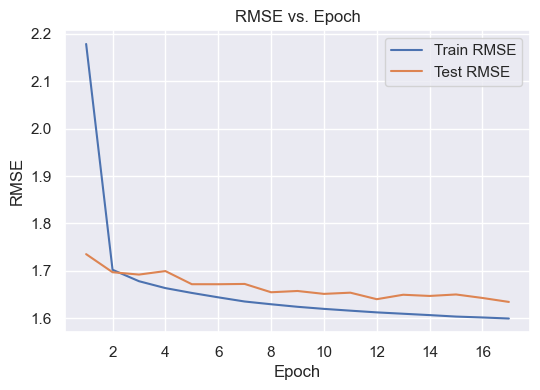

In [40]:
visualize_loss(train_losses, test_losses)

# Ground Truth Comparison

In [77]:
def visualize_predictions(model, device, path):
    """
    Compares a randomly selected data sample to the model's predictions
    path: path to a Pickle file containing scene data
    """
    model.eval()
    
    with open(path, 'rb') as file:
        scene = pickle.load(file)
    # Get the target agent id
    agent_id = scene['agent_id']        
    # Get the matrix of all agents
    track_id = scene['track_id']        
    # Get the location of the target agent in the matrix
    idx = np.nonzero(track_id[:, 0] == agent_id)[0][0]    
    pin, vin, pout = np.copy(scene['p_in'][idx]), np.copy(scene['v_in'][idx]), np.copy(scene['p_out'][idx])
    
    # Normalize the coordinates
    offset_x, offset_y = pin[0, 0], pin[0, 1]
    pin[:, 0] -= offset_x
    pin[:, 1] -= offset_y
    
    # Prepare tensors for model
    inp = [np.concatenate((pin, vin), axis=1)]
    inp = torch.FloatTensor(inp, device=DEVICE)
        
    # Sample number
    i = 0
    
    # Scene number
    scene_no = scene['scene_idx']
        
    # Get contiguous arrays of the ground truth output positions
    x = pout[:, 0]
    y = pout[:, 1] 
        
    # Get contiguous arrays of the prediction output positions
    output = model(inp)    
    pred = output[i].cpu().detach().numpy()
    xh = pred[:, 0] + offset_x
    yh = pred[:, 0] + offset_y   
    
    # Plot the ground truth and prediction positions
    fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Scene ' + str(scene_no))
    ax.scatter(scene['p_in'][idx][:, 0], scene['p_in'][idx][:, 1], label='Ground Truth Input Position')
    ax.scatter(x, y, label='Ground Truth Output Position')
    ax.scatter(xh, yh, label='Prediction Output Position')
    ax.legend(bbox_to_anchor=(1.1, 1.1))

In [49]:
import os
import pickle

In [50]:
# Get file names of original Pickle files
original_files = os.listdir('./original_train')

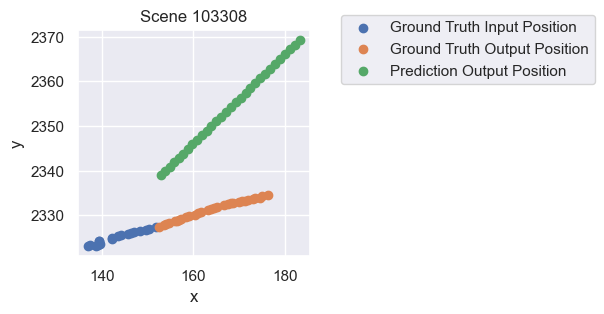

In [107]:
# Pick a random file
file = random.choice(original_files)
visualize_predictions(model, DEVICE, './original_train/' + file)

In [121]:
# Compare optimizers
opt_train_losses = {}
opt_test_losses = {}
names = ['Adadelta', 'Adagrad', 'Adam', 'AdamW', 'RMSprop', 'SGD', 'SGD with momentum and cyclic LR']

In [126]:
for (file, name) in zip(os.listdir('./report_opt'), names):
        checkpoint = torch.load('./report_opt/' + file, map_location=torch.device('cpu'))
        opt_train_losses[name] = checkpoint[LOSS_STATE][0]
        opt_test_losses[name] = checkpoint[LOSS_STATE][1]

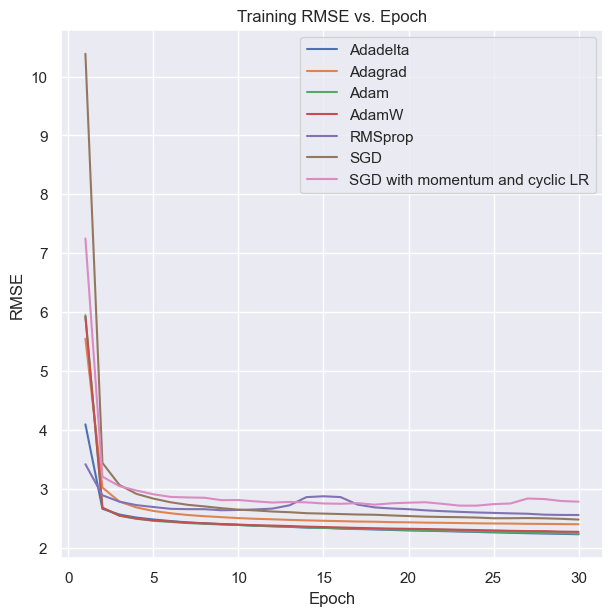

In [140]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
num_epochs = len(opt_train_losses['Adam']) + 1
t = np.arange(1, num_epochs, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.set_title('Training RMSE vs. Epoch')
for opt, losses in opt_train_losses.items():
    ax.plot(t, losses, label=opt)
ax.legend()
# ax.legend(bbox_to_anchor=(1.1, 1.1))

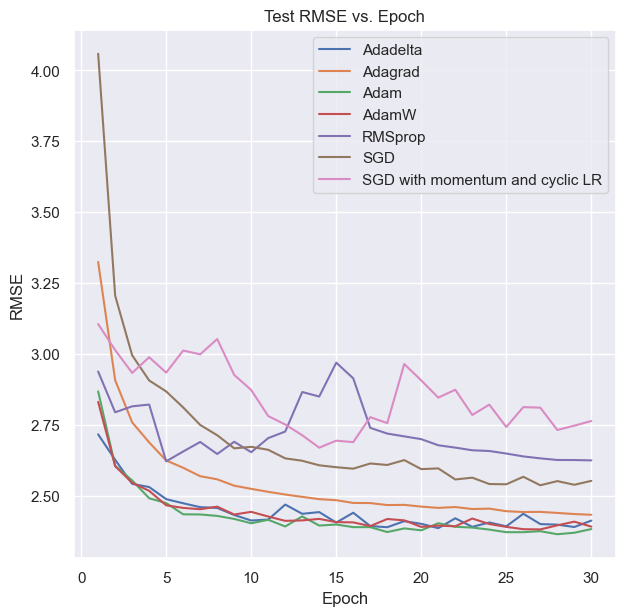

In [141]:
fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
num_epochs = len(opt_test_losses['Adam']) + 1
t = np.arange(1, num_epochs, 1)
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
ax.set_title('Test RMSE vs. Epoch')
for opt, losses in opt_test_losses.items():
    ax.plot(t, losses, label=opt)
ax.legend()
# ax.legend(bbox_to_anchor=(1.1, 1.1))